# Import библиотек

# Распознавание писателей



*Разбор данного раздела:* https://youtu.be/Wg5x4R0lROo?t=2428

In [ ]:
from google.colab import files #модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных
import pandas as pd #библиотека для обработки и анализа данных
import matplotlib.pyplot as plt #библиотека для визуализации данных
# "Магическая"команда python для запуска библиотеки в ноутбуке
%matplotlib inline

from tensorflow.keras import utils #модуль с утилитами кераса, будем использовать для вызова метода преобразования категорий в вектора
from tensorflow.keras.models import Sequential #последовательная модель нейросети кераса
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
# Загружаем алгоритмы обучения/оптимизации
from tensorflow.python.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence #инструменты предобработки текста от кераса
from sklearn.model_selection import train_test_split #модуль для разбиения данных на обучающую и тестовую выборки

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Загрузка данных


In [ ]:
###########################
# Чтение файла в текст
##########################
def readText(fileName): # функция принимает имя файла
  f = open(fileName, 'r')        # задаем открытие нужного файла в режиме чтения
  text = f.read()                # читаем текст
  text = text.replace("\n", " ") # переносы строки переводим в пробелы

  return text                    # функция возвращает текст файла

# Загружаем обучающие тексты
trainText = []
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(О. Генри) Обучающая_50 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Стругацкие) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Булгаков) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Клиффорд_Саймак) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Макс Фрай) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Рэй Брэдберри) Обучающая_22 вместе.txt'))

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдбери"]
nClasses = len(className)

# Загружаем тестовые тексты
testText = []
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(О. Генри) Тестовая_20 вместе.txt'))
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Стругацкие) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Булгаков) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Клиффорд_Саймак) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Макс Фрай) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Рэй Брэдберри) Тестовая_8 вместе.txt'))

## Обработка данных


*Разбор данного раздела:* https://youtu.be/Wg5x4R0lROo?t=2506

In [ ]:
#################
# Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 20000 # определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

# для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower=True, split=' ', char_level=False, oov_token = 'unknown')
# выше задаем параметры:
# (num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# (filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
# (lower=True) - приводим слова к нижнему регистру
# (split=' ') - разделяем слова по пробелу
# (char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(trainText) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) #вытаскиваем индексы слов для просмотра

In [ ]:
print(items[:100]) # взглянем на содержимое словаря

[('unknown', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5), ('что', 6), ('на', 7), ('с', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('это', 13), ('но', 14), ('все', 15), ('у', 16), ('по', 17), ('его', 18), ('к', 19), ('так', 20), ('мне', 21), ('из', 22), ('за', 23), ('меня', 24), ('ты', 25), ('же', 26), ('сказал', 27), ('бы', 28), ('было', 29), ('вы', 30), ('от', 31), ('они', 32), ('мы', 33), ('только', 34), ('да', 35), ('еще', 36), ('она', 37), ('о', 38), ('когда', 39), ('вот', 40), ('уже', 41), ('если', 42), ('был', 43), ('ни', 44), ('их', 45), ('нет', 46), ('чтобы', 47), ('до', 48), ('ну', 49), ('для', 50), ('ему', 51), ('может', 52), ('или', 53), ('ничего', 54), ('даже', 55), ('там', 56), ('очень', 57), ('кто', 58), ('ее', 59), ('тут', 60), ('потом', 61), ('просто', 62), ('него', 63), ('чем', 64), ('быть', 65), ('теперь', 66), ('под', 67), ('где', 68), ('нас', 69), ('есть', 70), ('тебя', 71), ('время', 72), ('ли', 73), ('тебе', 74), ('со', 75), ('во', 76), ('вас', 77), ('раз'

In [ ]:
print("Протестируем словарь частотности")
print("Интересующее слово имеет индекс: ", tokenizer.word_index[input("уточните слово: ")]) #протестируем словарь частотности

Протестируем словарь частотности
уточните слово: что
Интересующее слово имеет индекс:  6


In [ ]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)   # проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1] [:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20])

print()
print()

print("Статистика по обучающим текстам:")
for i in range(6):
  print(className[i], " ", len(trainText[i]), " символов, ", len(trainWordIndexes[i]), " слов")
print("В сумме ", len(trainText[0])+len(trainText[1])+len(trainText[2])+len(trainText[3])+len(trainText[4])+len(trainText[5]), " символов, ", len(trainWordIndexes[0])+len(trainWordIndexes[1])+len(trainWordIndexes[2])+len(trainWordIndexes[3])+len(trainWordIndexes[4])+len(trainWordIndexes[5]), " слов")
print()
print("Статистика по обучающим текстам:")
for i in range(6):
  print(className[i], " ", len(testText[i]), " символов, ", len(testWordIndexes[i]), " слов")
print("В сумме ", len(testText[0])+len(testText[1])+len(testText[2])+len(testText[3])+len(testText[4])+len(testText[5]), " символов, ", len(testWordIndexes[0])+len(testWordIndexes[1])+len(testWordIndexes[2])+len(testWordIndexes[3])+len(testWordIndexes[4])+len(testWordIndexes[5]), " слов")

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал
Он же в виде последовательности индексов:  [470, 22, 1, 1482, 49, 2, 12725, 7723, 5, 415, 1, 4, 252, 2, 4, 247, 55, 6, 240, 10517]


Статистика по обучающим текстам:
О. Генри   1049517  символов,  160682  слов
Стругацкие   2042469  символов,  313405  слов
Булгаков   1765648  символов,  262109  слов
Саймак   1609507  символов,  251551  слов
Фрай   3700010  символов,  569052  слов
Брэдбери   1386454  символов,  214694  слов
В сумме  11553605  символов,  1771493  слов

Статистика по обучающим текстам:
О. Генри   349662  символов,  53255  слов
Стругацкие   704846  символов,  108730  слов
Булгаков   875042  символов,  132910  слов
Саймак   318811  символов,  50362  слов
Фрай   1278191  символов,  196911  слов
Брэдбери   868673  символов,  132746  слов
В сумме  4395225  символов,  674914  слов


## Создание обучающей и проверочной выборки

*Разбор данного раздела:* https://youtu.be/Wg5x4R0lROo?t=2553

**Функции для формирования выборки по отрезкам текста с заданным шагом**

In [ ]:
###########################
# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
##########################
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0

  # Идём по всей длине вектора индексов
  # "Откусываем" векторы длины xLen и смещаеммся вперёд на step

  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step

  return xSample

In [ ]:
###########################
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
##########################
def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов выборки
  classesXSamples = []        # здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна(например 6 по 1341*1000)"
  for wI in wordIndexes:      # для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна"

  # Формируем один общий xSamples
  xSamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна(например 15779*1000)"
  ySamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"

  for t in range(nClasses):  # в диапазоне кол-ва классов(6)
    xT = classesXSamples[t]  # берем очередной текст вида "кол-во окон в тексте*длину окна"(например 1341*1000)
    for i in range(len(xT)): # и каждое его окно
      xSamples.append(xT[i]) # добавляем в общий список выборки

    # Формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 6 вида [0.0.0.1.0.0.]
    for i in range(len(xT)): # на каждое окно выборки
      ySamples.append(currY) # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку


  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

**Подготовка данных**

In [ ]:
# Задаём базовые параметры
xLen = 1000 # Длина отрезка текста, по которой анализируем, в словах
step = 100 # Шаг разбиения исходного текста на обучающие вектора

In [ ]:
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
# получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1

(17658, 1000)
(17658, 6)
(6693, 1000)
(6693, 6)


## Распознавание проверочной выборки


*Разбор данного раздела:* https://youtu.be/Wg5x4R0lROo?t=2633

In [ ]:
###########################
# Представляем тестовую выборку в удобных для распознавания размерах
##########################
def createTestMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов
  xTest6Classes01 = []               # здесь будет список из всех классов,каждый размером "кол-во окон в тексте * 20000(при maxWordsCount=20000)"
  xTest6Classes = []                 # здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:             # для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) # тестовая выборка размером "кол-во окон*длину окна"(например 420*1000)
    xTest6Classes.append(np.array(sample))       # переводим в массив numpy и добавляем в список
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) # трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
  xTest6Classes01 = np.array(xTest6Classes01)                     # и добавляется к нашему списку,

  return xTest6Classes01, xTest6Classes # функция вернёт тестовые данные: TestBg 6 классов на n*20000 и xTestEm 6 по n*1000

###########################
# Расспознаём тестовую выборку и выводим результаты
##########################
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()

  val = []
  pred = []

  totalSumRec = []

  # Проходим по всем классам
  for i in range(nClasses):
    # Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    # Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    # Считаем процент распознавания каждого класса за каждый
    # Получам матрицу 6 на 6
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))

    totalSumRec.append(sumRec[i])

    # Определяем, какой в класс в итоге за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)

    # Выводим результаты распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)

  # Выводим вредний процент распознавания по всем классам вместе
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
  print()
  return sumVal/sumCount

xTest6Classes01, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) # подгоним форму тестовых классов под функцию recognizeMultiClass

## Рекуррентная нейросеть

*Разбор данного раздела:* https://youtu.be/Wg5x4R0lROo?t=2652

**Simple RNN / GRU / LSTM**



Epoch 1/2
35/35 [==============================] - 33s 939ms/step - loss: 1.8788 - accuracy: 0.1528 - val_loss: 1.7878 - val_accuracy: 0.2618
Epoch 2/2
35/35 [==============================] - 33s 944ms/step - loss: 1.7978 - accuracy: 0.2404 - val_loss: 1.7834 - val_accuracy: 0.2854


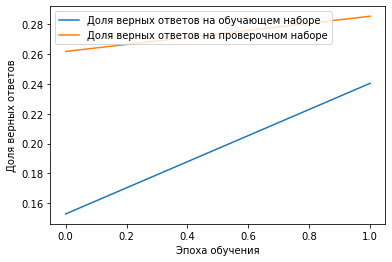

НЕЙРОНКА:  SimpleRNN

О. Генри  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  3 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Саймак  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Фрай  распознано  95 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!

Средний процент распознавания  28 %



In [ ]:
modelEL = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(SimpleRNN(4, dropout=0.2, recurrent_dropout=0.2, activation="relu"))
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrain,
                    yTrain,
                    epochs=2,
                    batch_size=512,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "SimpleRNN") #функция покажет какие классы и как распознаны верно

Epoch 1/2
35/35 [==============================] - 165s 5s/step - loss: 1.8270 - accuracy: 0.1424 - val_loss: 1.7854 - val_accuracy: 0.2928
Epoch 2/2
35/35 [==============================] - 165s 5s/step - loss: 1.7744 - accuracy: 0.1980 - val_loss: 1.7793 - val_accuracy: 0.2928


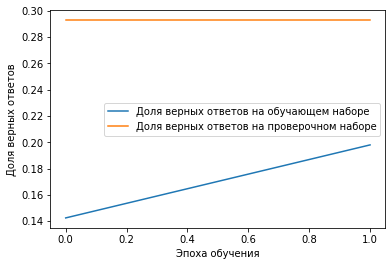

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Саймак  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Фрай  распознано  100 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!

Средний процент распознавания  29 %



In [ ]:
modelEL = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(GRU(4, dropout=0.2, recurrent_dropout=0.2, activation="relu"))
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrain,
                    yTrain,
                    epochs=2,
                    batch_size=512,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

Epoch 1/20
35/35 [==============================] - 2s 69ms/step - loss: 1.7535 - accuracy: 0.2935 - val_loss: 1.7624 - val_accuracy: 0.2928
Epoch 2/20
35/35 [==============================] - 2s 58ms/step - loss: 1.6848 - accuracy: 0.3502 - val_loss: 1.7408 - val_accuracy: 0.2928
Epoch 3/20
35/35 [==============================] - 2s 59ms/step - loss: 1.6157 - accuracy: 0.3833 - val_loss: 1.7276 - val_accuracy: 0.2928
Epoch 4/20
35/35 [==============================] - 2s 58ms/step - loss: 1.5287 - accuracy: 0.4410 - val_loss: 1.6673 - val_accuracy: 0.3045
Epoch 5/20
35/35 [==============================] - 2s 59ms/step - loss: 1.4223 - accuracy: 0.4905 - val_loss: 1.8520 - val_accuracy: 0.2105
Epoch 6/20
35/35 [==============================] - 2s 59ms/step - loss: 1.3393 - accuracy: 0.5129 - val_loss: 1.8946 - val_accuracy: 0.2030
Epoch 7/20
35/35 [==============================] - 2s 59ms/step - loss: 1.2907 - accuracy: 0.5252 - val_loss: 1.9040 - val_accuracy: 0.2042
Epoch 8/20
35

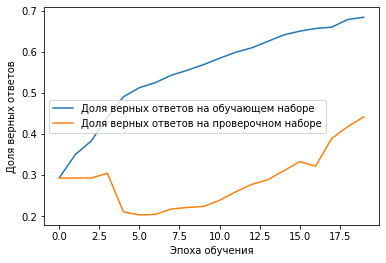

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  3 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  50 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  40 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  17 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Фрай  распознано  80 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  14 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!

Средний процент распознавания  44 %



In [ ]:
modelEL = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(LSTM(4))
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrain,
                    yTrain,
                    epochs=20,
                    batch_size=512,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

Epoch 1/50
35/35 [==============================] - 4s 122ms/step - loss: 1.7444 - accuracy: 0.1948 - val_loss: 1.7581 - val_accuracy: 0.1611
Epoch 2/50
35/35 [==============================] - 4s 105ms/step - loss: 1.6469 - accuracy: 0.2649 - val_loss: 1.7249 - val_accuracy: 0.2930
Epoch 3/50
35/35 [==============================] - 4s 106ms/step - loss: 1.5218 - accuracy: 0.3547 - val_loss: 1.6837 - val_accuracy: 0.2314
Epoch 4/50
35/35 [==============================] - 4s 105ms/step - loss: 1.4080 - accuracy: 0.4648 - val_loss: 1.6072 - val_accuracy: 0.2884
Epoch 5/50
35/35 [==============================] - 4s 105ms/step - loss: 1.3215 - accuracy: 0.5314 - val_loss: 1.8602 - val_accuracy: 0.2634
Epoch 6/50
35/35 [==============================] - 4s 105ms/step - loss: 1.2612 - accuracy: 0.5065 - val_loss: 1.8689 - val_accuracy: 0.2728
Epoch 7/50
35/35 [==============================] - 4s 106ms/step - loss: 1.2260 - accuracy: 0.4994 - val_loss: 1.9526 - val_accuracy: 0.2571
Epoch 

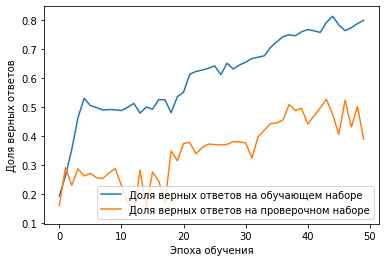

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  0 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  84 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  32 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Саймак  распознано  44 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  20 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Брэдбери  распознано  48 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  39 %



In [ ]:
modelEL = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization())  # добавляем слой нормализации данных
modelEL.add(LSTM(4, return_sequences=True))
modelEL.add(LSTM(4))
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrain,
                    yTrain,
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно

**LSTM + Dense**



*Разбор данного раздела:* https://youtu.be/Wg5x4R0lROo?t=6060

Epoch 1/20
89/89 [==============================] - 5s 55ms/step - loss: 2.0578 - accuracy: 0.2305 - val_loss: 1.7329 - val_accuracy: 0.2928
Epoch 2/20
89/89 [==============================] - 4s 48ms/step - loss: 1.8774 - accuracy: 0.2770 - val_loss: 1.7319 - val_accuracy: 0.2928
Epoch 3/20
89/89 [==============================] - 4s 48ms/step - loss: 1.7674 - accuracy: 0.3105 - val_loss: 1.7073 - val_accuracy: 0.2933
Epoch 4/20
89/89 [==============================] - 4s 47ms/step - loss: 1.6213 - accuracy: 0.3677 - val_loss: 1.6656 - val_accuracy: 0.3153
Epoch 5/20
89/89 [==============================] - 4s 48ms/step - loss: 1.4431 - accuracy: 0.4242 - val_loss: 1.7070 - val_accuracy: 0.2943
Epoch 6/20
89/89 [==============================] - 4s 48ms/step - loss: 1.3845 - accuracy: 0.4539 - val_loss: 1.7074 - val_accuracy: 0.3323
Epoch 7/20
89/89 [==============================] - 4s 48ms/step - loss: 1.3340 - accuracy: 0.4604 - val_loss: 1.8517 - val_accuracy: 0.3287
Epoch 8/20
89

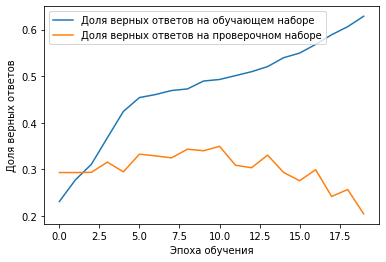

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  0 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  53 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  0 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Саймак  распознано  84 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  6 % сеть считает, что это  Саймак ,  распознано НЕ ВЕРНО!
Брэдбери  распознано  19 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!

Средний процент распознавания  20 %



In [ ]:
modelEL = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEL.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization())  # добавляем слой нормализации данных
modelEL.add(LSTM(4)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEL.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(Dense(100, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEL.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrain,
                    yTrain,
                    epochs=20,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно

**LSTM + Dense через последовательности**

*Разбор данного раздела:* https://youtu.be/Wg5x4R0lROo?t=6154

Epoch 1/30
89/89 [==============================] - 7s 75ms/step - loss: 2.6455 - accuracy: 0.5012 - val_loss: 3.6548 - val_accuracy: 0.2928
Epoch 2/30
89/89 [==============================] - 6s 71ms/step - loss: 0.8036 - accuracy: 0.8410 - val_loss: 16.0829 - val_accuracy: 0.2928
Epoch 3/30
89/89 [==============================] - 6s 72ms/step - loss: 0.4067 - accuracy: 0.9307 - val_loss: 15.8113 - val_accuracy: 0.0781
Epoch 4/30
89/89 [==============================] - 6s 72ms/step - loss: 0.3428 - accuracy: 0.9510 - val_loss: 15.4181 - val_accuracy: 0.1479
Epoch 5/30
89/89 [==============================] - 6s 70ms/step - loss: 0.2673 - accuracy: 0.9627 - val_loss: 26.6826 - val_accuracy: 0.0962
Epoch 6/30
89/89 [==============================] - 6s 70ms/step - loss: 0.2628 - accuracy: 0.9646 - val_loss: 19.7005 - val_accuracy: 0.2916
Epoch 7/30
89/89 [==============================] - 6s 70ms/step - loss: 0.2349 - accuracy: 0.9731 - val_loss: 9.3672 - val_accuracy: 0.5966
Epoch 8/

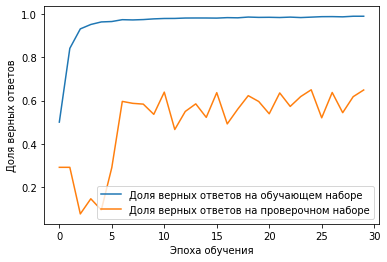

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  56 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  42 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  81 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  30 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Фрай  распознано  67 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  79 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  64 %



In [ ]:
modelEL = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEL.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization())  # добавляем слой нормализации данных
modelEL.add(LSTM(4, return_sequences=True)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEL.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(Dense(100, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEL.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrain,
                    yTrain,
                    epochs=30,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

**Двунаправленная LSTM**



*Разбор данного раздела:* https://youtu.be/Wg5x4R0lROo?t=6412

Epoch 1/5
89/89 [==============================] - 30s 340ms/step - loss: 1.9400 - accuracy: 0.2624 - val_loss: 1.7350 - val_accuracy: 0.2928
Epoch 2/5
89/89 [==============================] - 29s 327ms/step - loss: 1.4935 - accuracy: 0.4199 - val_loss: 1.9407 - val_accuracy: 0.1611
Epoch 3/5
89/89 [==============================] - 29s 327ms/step - loss: 1.1735 - accuracy: 0.5238 - val_loss: 2.1312 - val_accuracy: 0.1624
Epoch 4/5
89/89 [==============================] - 29s 331ms/step - loss: 0.9528 - accuracy: 0.6292 - val_loss: 1.9031 - val_accuracy: 0.3187
Epoch 5/5
89/89 [==============================] - 30s 334ms/step - loss: 0.7054 - accuracy: 0.7365 - val_loss: 3.4970 - val_accuracy: 0.3209


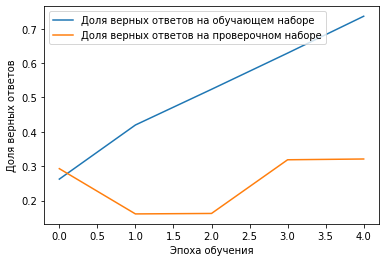

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  0 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  21 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Булгаков  распознано  95 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  0 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Фрай  распознано  32 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  0 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!

Средний процент распознавания  32 %



In [ ]:
modelEL = Sequential() #создаём последовательную модель нейросети

#преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 50, input_length=xLen))

modelEL.add(SpatialDropout1D(0.4)) #добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization()) #добавляем слой нормализации данных
modelEL.add(Bidirectional(LSTM(8, return_sequences=1))) #добавляем слой с двунаправленным LSTM, совместимый с Cuda при поддержке GPU
modelEL.add(Bidirectional(LSTM(8, return_sequences=1))) #добавляем слой с двунаправленным LSTM, совместимый с Cuda при поддержке GPU
modelEL.add(Dropout(0.3)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) #добавляем слой нормализации данных
modelEL.add(GRU(16, return_sequences=True, reset_after=True)) #добавляем слой GRU, совместимый с Cuda при поддержке GPU
modelEL.add(GRU(16, reset_after=True)) #добавляем слой GRU, совместимый с Cuda при поддержке GPU
modelEL.add(Dropout(0.3)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) #добавляем слой нормализации данных
modelEL.add(Dense(200, activation='relu')) #добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEL.add(Dropout(0.3)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) #добавляем слой нормализации данных
modelEL.add(Dense(6, activation='softmax')) #добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrain,
                    yTrain,
                    epochs=5,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

## Conv1D



*Разбор данного раздела:* https://youtu.be/Wg5x4R0lROo?t=7326

Epoch 1/20
89/89 [==============================] - 2s 20ms/step - loss: 1.1455 - accuracy: 0.5990 - val_loss: 2.6723 - val_accuracy: 0.1611
Epoch 2/20
89/89 [==============================] - 2s 18ms/step - loss: 0.0513 - accuracy: 0.9843 - val_loss: 4.7143 - val_accuracy: 0.1611
Epoch 3/20
89/89 [==============================] - 2s 18ms/step - loss: 0.0142 - accuracy: 0.9955 - val_loss: 6.8715 - val_accuracy: 0.1980
Epoch 4/20
89/89 [==============================] - 2s 18ms/step - loss: 0.0086 - accuracy: 0.9969 - val_loss: 4.1884 - val_accuracy: 0.4466
Epoch 5/20
89/89 [==============================] - 2s 18ms/step - loss: 0.0097 - accuracy: 0.9965 - val_loss: 5.9937 - val_accuracy: 0.3371
Epoch 6/20
89/89 [==============================] - 2s 18ms/step - loss: 0.0087 - accuracy: 0.9969 - val_loss: 3.1651 - val_accuracy: 0.5156
Epoch 7/20
89/89 [==============================] - 2s 18ms/step - loss: 0.0071 - accuracy: 0.9976 - val_loss: 2.5828 - val_accuracy: 0.5612
Epoch 8/20
89

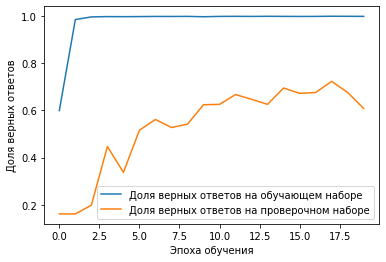

НЕЙРОНКА:  Embedding + Dense

О. Генри  распознано  35 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  81 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  32 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Саймак  распознано  41 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Фрай  распознано  83 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  55 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  60 %



In [ ]:
modelEC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(BatchNormalization())  # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
#modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEC.fit(xTrain,
                    yTrain,
                    epochs=20,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEC, xTest6Classes, "Embedding + Dense") #функция покажет какие классы и как распознаны верно

In [ ]:
print(modelEC.summary()) # выведем на экран данные о модели

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 1000, 10)          0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 1000, 10)          40        
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 20)           1020      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 992, 20)           2020      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 496, 20)           0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 496, 20)         

**Conv1D + Dense**




*Разбор данного раздела:* https://youtu.be/Wg5x4R0lROo?t=7524

Epoch 1/20
89/89 [==============================] - 4s 43ms/step - loss: 1.4226 - accuracy: 0.4678 - val_loss: 1.8665 - val_accuracy: 0.1972
Epoch 2/20
89/89 [==============================] - 4s 40ms/step - loss: 0.7220 - accuracy: 0.8190 - val_loss: 2.1678 - val_accuracy: 0.1972
Epoch 3/20
89/89 [==============================] - 4s 40ms/step - loss: 0.3597 - accuracy: 0.9428 - val_loss: 2.3269 - val_accuracy: 0.1972
Epoch 4/20
89/89 [==============================] - 4s 40ms/step - loss: 0.2009 - accuracy: 0.9699 - val_loss: 2.1860 - val_accuracy: 0.1972
Epoch 5/20
89/89 [==============================] - 4s 40ms/step - loss: 0.1236 - accuracy: 0.9802 - val_loss: 1.8455 - val_accuracy: 0.2546
Epoch 6/20
89/89 [==============================] - 4s 40ms/step - loss: 0.0826 - accuracy: 0.9857 - val_loss: 1.7207 - val_accuracy: 0.3646
Epoch 7/20
89/89 [==============================] - 4s 41ms/step - loss: 0.0628 - accuracy: 0.9867 - val_loss: 1.6351 - val_accuracy: 0.4367
Epoch 8/20
89

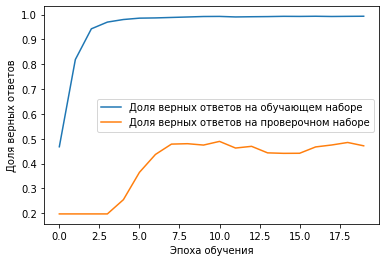

НЕЙРОНКА:  Embedding + Dense

О. Генри  распознано  60 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  4 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  26 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Саймак  распознано  34 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  84 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  46 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  47 %



In [ ]:
modelEC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 50, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(BatchNormalization())  # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(Conv1D(20, 5, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(GlobalMaxPooling1D()) # добавляем слой подвыборки/пулинга с функцией максимума(по всей длине входящей последовательности)
#modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(20, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEC.fit(xTrain,
                    yTrain,
                    epochs=20,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEC, xTest6Classes, "Embedding + Dense") #функция покажет какие классы и как распознаны верно

In [ ]:
print(modelEC.summary()) # выведем на экран данные о модели

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 1000, 50)          1000000   
_________________________________________________________________
spatial_dropout1d_16 (Spatia (None, 1000, 50)          0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 1000, 50)          200       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 20)          5020      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 20)          2020      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 20)           0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 500, 20)         

Epoch 1/20
89/89 [==============================] - 2s 27ms/step - loss: 1.7066 - accuracy: 0.3455 - val_loss: 2.1356 - val_accuracy: 0.0781
Epoch 2/20
89/89 [==============================] - 2s 23ms/step - loss: 0.7756 - accuracy: 0.6815 - val_loss: 5.5680 - val_accuracy: 0.0781
Epoch 3/20
89/89 [==============================] - 2s 23ms/step - loss: 0.1714 - accuracy: 0.9365 - val_loss: 13.5081 - val_accuracy: 0.1945
Epoch 4/20
89/89 [==============================] - 2s 23ms/step - loss: 0.0683 - accuracy: 0.9781 - val_loss: 10.3732 - val_accuracy: 0.2821
Epoch 5/20
89/89 [==============================] - 2s 23ms/step - loss: 0.0381 - accuracy: 0.9888 - val_loss: 8.4027 - val_accuracy: 0.3710
Epoch 6/20
89/89 [==============================] - 2s 23ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 6.6314 - val_accuracy: 0.3988
Epoch 7/20
89/89 [==============================] - 2s 23ms/step - loss: 0.0288 - accuracy: 0.9920 - val_loss: 7.0975 - val_accuracy: 0.4028
Epoch 8/20


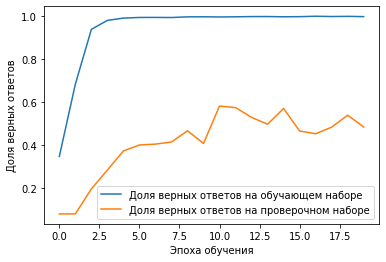

НЕЙРОНКА:  Embedding + Dense

О. Генри  распознано  60 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  11 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  51 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  14 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Фрай  распознано  90 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  19 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!

Средний процент распознавания  48 %



In [ ]:
modelEC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(BatchNormalization())  # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(64, activation='relu')) # добавляем полносвязный слой на 64 нейрона, с функцией активации relu
modelEC.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEC.fit(xTrain,
                    yTrain,
                    epochs=20,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEC, xTest6Classes, "Embedding + Dense") #функция покажет какие классы и как распознаны верно

In [ ]:
modelEC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 50, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(BatchNormalization())  # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(GlobalMaxPooling1D()) # добавляем слой подвыборки/пулинга с функцией максимума(по всей длине входящей последовательности)
#modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(20, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(modelEC.summary()) # выведем на экран данные о модели

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 1000, 50)          1000000   
_________________________________________________________________
spatial_dropout1d_17 (Spatia (None, 1000, 50)          0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 1000, 50)          200       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 996, 20)           5020      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 498, 20)           0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 498, 20)           0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 498, 20)         

**LSTM + Conv1D**



*Разбор данного раздела:* https://youtu.be/Wg5x4R0lROo?t=7859

Epoch 1/5
89/89 [==============================] - 11s 118ms/step - loss: 0.8603 - accuracy: 0.6383 - val_loss: 3.2024 - val_accuracy: 0.1969
Epoch 2/5
89/89 [==============================] - 10s 111ms/step - loss: 0.1096 - accuracy: 0.9643 - val_loss: 4.3955 - val_accuracy: 0.1611
Epoch 3/5
89/89 [==============================] - 10s 110ms/step - loss: 0.0420 - accuracy: 0.9866 - val_loss: 4.6989 - val_accuracy: 0.1969
Epoch 4/5
89/89 [==============================] - 10s 110ms/step - loss: 0.0297 - accuracy: 0.9905 - val_loss: 4.3305 - val_accuracy: 0.3782
Epoch 5/5
89/89 [==============================] - 10s 110ms/step - loss: 0.0225 - accuracy: 0.9934 - val_loss: 5.6128 - val_accuracy: 0.3366


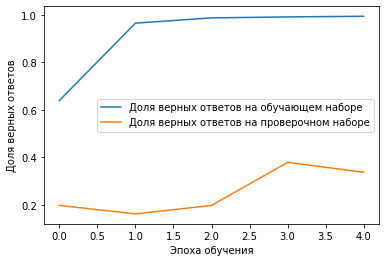

НЕЙРОНКА:  Embedding + Dense

О. Генри  распознано  48 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  1 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  0 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Саймак  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Фрай  распознано  97 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  6 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!

Средний процент распознавания  33 %



In [ ]:
modelEC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(LSTM(4, return_sequences=True)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEC.add(Dense(100, activation='relu')) # добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(LSTM(4, return_sequences=True)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEC.fit(xTrain,
                    yTrain,
                    epochs=5,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEC, xTest6Classes, "Embedding + Dense") #функция покажет какие классы и как распознаны верно

In [ ]:
modelEC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(LSTM(4, return_sequences=True)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEC.add(Dense(100, activation='relu')) # добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(LSTM(4, return_sequences=True)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(modelEC.summary()) # выведем на экран данные о модели

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 1000, 10)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1000, 4)           240       
_________________________________________________________________
dense_16 (Dense)             (None, 1000, 100)         500       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 996, 20)           10020     
_________________________________________________________________
lstm_10 (LSTM)               (None, 996, 4)            400       
_________________________________________________________________
dropout_15 (Dropout)         (None, 996, 4)          

In [ ]:
print(modelEC.summary()) # выведем на экран данные о модели

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d_19 (Spatia (None, 1000, 10)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 1000, 4)           240       
_________________________________________________________________
dense_34 (Dense)             (None, 1000, 100)         500       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 996, 20)           10020     
_________________________________________________________________
lstm_14 (LSTM)               (None, 996, 4)            400       
_________________________________________________________________
dropout_26 (Dropout)         (None, 996, 4)          

**Conv1D + LSTM**

Epoch 1/5
89/89 [==============================] - 3s 37ms/step - loss: 0.9403 - accuracy: 0.6517 - val_loss: 3.0287 - val_accuracy: 0.1993
Epoch 2/5
89/89 [==============================] - 3s 33ms/step - loss: 0.0502 - accuracy: 0.9850 - val_loss: 4.7819 - val_accuracy: 0.2060
Epoch 3/5
89/89 [==============================] - 3s 33ms/step - loss: 0.0202 - accuracy: 0.9931 - val_loss: 5.6223 - val_accuracy: 0.2748
Epoch 4/5
89/89 [==============================] - 3s 33ms/step - loss: 0.0174 - accuracy: 0.9950 - val_loss: 5.9228 - val_accuracy: 0.3259
Epoch 5/5
89/89 [==============================] - 3s 33ms/step - loss: 0.0129 - accuracy: 0.9963 - val_loss: 3.5217 - val_accuracy: 0.3357


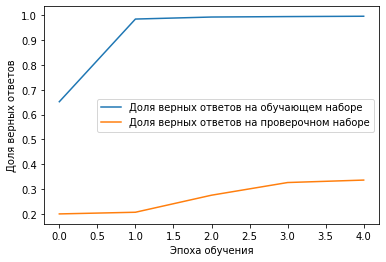

НЕЙРОНКА:  Embedding + Dense

О. Генри  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  7 % сеть считает, что это  Саймак ,  распознано НЕ ВЕРНО!
Булгаков  распознано  0 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Саймак  распознано  98 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  84 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  1 % сеть считает, что это  Саймак ,  распознано НЕ ВЕРНО!

Средний процент распознавания  33 %



In [ ]:
modelEC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEC.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization()) # добавляем слой нормализации данных
modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEC.fit(xTrain,
                    yTrain,
                    epochs=5,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEC, xTest6Classes, "Embedding + Dense") # функция покажет какие классы и как распознаны верно

**Дообучение**

*Разбор данного раздела:* https://youtu.be/Wg5x4R0lROo?t=8074

Epoch 1/5
89/89 [==============================] - 6s 62ms/step - loss: 1.9882 - accuracy: 0.1690 - val_loss: 1.7501 - val_accuracy: 0.2916
Epoch 2/5
89/89 [==============================] - 4s 48ms/step - loss: 1.8219 - accuracy: 0.2325 - val_loss: 1.7336 - val_accuracy: 0.2930
Epoch 3/5
89/89 [==============================] - 4s 48ms/step - loss: 1.7265 - accuracy: 0.2980 - val_loss: 1.7217 - val_accuracy: 0.2933
Epoch 4/5
89/89 [==============================] - 4s 49ms/step - loss: 1.6681 - accuracy: 0.3342 - val_loss: 1.7106 - val_accuracy: 0.2930
Epoch 5/5
89/89 [==============================] - 4s 49ms/step - loss: 1.6181 - accuracy: 0.3630 - val_loss: 1.6873 - val_accuracy: 0.2928
Epoch 1/5
89/89 [==============================] - 5s 53ms/step - loss: 1.5527 - accuracy: 0.3882 - val_loss: 1.6433 - val_accuracy: 0.3026
Epoch 2/5
89/89 [==============================] - 4s 49ms/step - loss: 1.4784 - accuracy: 0.4149 - val_loss: 1.5741 - val_accuracy: 0.3242
Epoch 3/5
89/89 [===

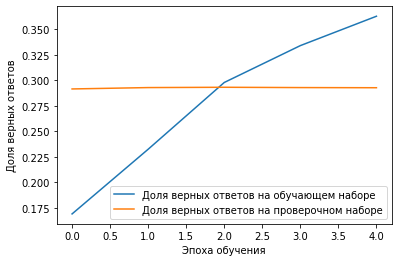

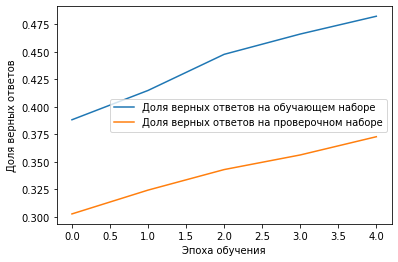

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  0 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  67 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  13 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Саймак  распознано  3 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Фрай  распознано  80 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  0 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!

Средний процент распознавания  37 %



In [ ]:
modelEL = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEL.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(GRU(4)) # добавляем слой GRU, совместимый с Cuda при поддержке GPU
modelEL.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history1 = modelEL.fit(xTrain,
                    yTrain,
                    epochs=5,
                    batch_size=200,
                    validation_data=(xTest, yTest))
# Снова компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Дообучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history2 = modelEL.fit(xTrain,
                    yTrain,
                    epochs=5,
                    batch_size=200,
                    validation_data=(xTest, yTest))

# Строим 1й график для отображения динамики обучения и точности предсказания сети
plt.plot(history1.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history1.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Строим 2й график для отображения динамики обучения и точности предсказания сети
plt.plot(history2.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history2.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно